<a href="https://colab.research.google.com/github/JingfengSteven/NAM_Model_Monotonicity/blob/Model/Model_training%20(strong%2Cindividual)%20modified1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/JingfengSteven/givemesomecredit

Cloning into 'givemesomecredit'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 25 (delta 11), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (25/25), 4.40 MiB | 2.91 MiB/s, done.
Resolving deltas: 100% (11/11), done.


In [2]:
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
from givemesomecredit import models as nam_models
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn

##Data reading

In [3]:
orgdata=pd.read_csv("givemesomecredit/cs-training.csv")
orgdata=orgdata.dropna(axis=0)
orgdata.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
data=orgdata

In [5]:
x=data.iloc[:,2:data.shape[1]]
y=data.iloc[:,1]
x.insert(data.shape[1]-2, 'label', y)
x.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,label
0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,1
1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0
2,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,0
3,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0
4,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,0


In [6]:
x=np.array(x)
x.shape

(120269, 11)

##Data cleaning

In [7]:
x[:,[0,2]]=x[:,[2,0]]
x[:,[1,8]]=x[:,[8,1]]
x[:,[2,6]]=x[:,[6,2]]
x[:,[3,4]]=x[:,[4,3]]
x[:,[4,9]]=x[:,[9,4]]

In [8]:
x1=x

##First three feature are 3-pairwise, the last two feature are single

In [9]:
x1 = np.delete(x1, np.where
    (x1[:,0] >= 20), axis=0)
x1 = np.delete(x1, np.where
    (x1[:,1] >= 20), axis=0)
x1 = np.delete(x1, np.where
    (x1[:,2] >= 20), axis=0)

In [10]:
x1.shape

(120121, 11)

In [11]:
x1[:,0][x1[:,0]>=4]=4
x1[:,1][x1[:,1]>=4]=4
x1[:,2][x1[:,2]>=4]=4

In [12]:
x1[:,3][(x1[:,3]>=0)&(x1[:,3]<2500)]=5
x1[:,3][(x1[:,3]>=2500)&(x1[:,3]<5000)]=4
x1[:,3][(x1[:,3]>=5000)&(x1[:,3]<7500)]=3
x1[:,3][(x1[:,3]>=7500)&(x1[:,3]<10000)]=2
x1[:,3][(x1[:,3]>=10000)&(x1[:,3]<50000)]=1
x1[:,3][x1[:,3]>=50000]=0

In [13]:
x1[:,4][x1[:,4]>=5]=5

In [14]:
X=x1[:,0:len(x1[0])-1]
Y=x1[:,-1]

In [46]:
X[0]

array([ 2.        ,  0.        ,  0.        ,  2.        ,  2.        ,
       13.        ,  0.76612661,  6.        , 45.        ,  0.80298213])

##Build the model

In [59]:
tf.compat.v1.reset_default_graph()
#the change of the structure of NAM is in kwargs)
#in this demo, first three feature are strong monotonicity, thereby, they are combined in a DNN.
Number_of_DNN=8
Number_of_Unit=0
Trainable=True
Use_Shallow=False
Model=nam_models.NAM(Number_of_DNN,Number_of_Unit,Trainable,Use_Shallow,feature_dropout = 0.0,dropout = 0.0,kwargs=[3,1,1,1,1,1,1,1])
Model(X)

<tf.Tensor: shape=(120121,), dtype=float32, numpy=
array([0.6749816 , 0.27765596, 0.30749434, ..., 0.3131144 , 0.30555996,
       0.44011533], dtype=float32)>

In [16]:
Model.summary()

Model: "nam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_nn (FeatureNN)      multiple                  21        
                                                                 
 feature_nn_1 (FeatureNN)    multiple                  13        
                                                                 
 feature_nn_2 (FeatureNN)    multiple                  13        
                                                                 
 feature_nn_3 (FeatureNN)    multiple                  13        
                                                                 
 feature_nn_4 (FeatureNN)    multiple                  13        
                                                                 
 feature_nn_5 (FeatureNN)    multiple                  13        
                                                                 
 feature_nn_6 (FeatureNN)    multiple                  13      

##Single monotonicity

In [17]:
def descretize_single(monotonic_feature,lower_bound,upper_bound,spli,X):
  individual_output=[]
  bar=np.zeros(len(monotonic_feature))
  for i in range(len(monotonic_feature)):
    individual_output.append(np.linspace(lower_bound[i], upper_bound[i], num=spli[i]))
  return individual_output
X=X
monotonic_feature=[3,4]
lower_bound=[0,0]
upper_bound=[5,5]
spli=[6,6]
individual_output=descretize_single(monotonic_feature,lower_bound,upper_bound,spli,X)

In [18]:
individual_output

[array([0., 1., 2., 3., 4., 5.]), array([0., 1., 2., 3., 4., 5.])]

##3-strong-pair monotonicity

In [19]:
def descretize_3_pair():
  lower_bound=0
  upper_bound=4
  pair=[]
  pair1=[]
  pair2=[]
  pair3=[]
  for i in range(5):
    for j in range(5):
      for k in range(5):
        pair.append([i,j,k])
        pair1.append([i,j+1,k-1])
        pair2.append([i+1,j-1,k])
        pair3.append([i-1,j,k])
  return pair,pair1,pair2,pair3

In [20]:
#f(pair) is smaller than f(pair1),f(pair2),f(pair3)
pair,pair1,pair2,pair3=descretize_3_pair()

## Single monotonicity in that 3-strong-pair monotonicity

In [21]:
def descretize_3_pair_single():
  pair_s=[]
  pair_s1=[]
  for i in range(5):
    for j in range(5):
      for k in range(4):
        pair_s.append([k+1,i,j])
        pair_s1.append([k,i,j])

  for i in range(5):
    for j in range(5):
      for k in range(4):
        pair_s.append([i,k+1,j])
        pair_s1.append([i,k,j])

  for i in range(5):
    for j in range(5):
      for k in range(4):
        pair_s.append([i,j,k+1])
        pair_s1.append([i,j,k])
  return pair_s, pair_s1

In [22]:
#f(pair_s) is smaller than f(pair_s1)
pair_s, pair_s1=descretize_3_pair_single()

##Pre_training

In [60]:
Model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics='AUC')

training_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience = 5, factor = 0.1, min_lr = 0.001, verbose = 1),
    tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True),
]

Model.fit(X, Y, batch_size=64, epochs=10)

Epoch 1/10
1877/1877 [==============================] - 13s 5ms/step - loss: 0.2212 - auc: 0.7639
Epoch 2/10
1877/1877 [==============================] - 9s 5ms/step - loss: 0.1931 - auc: 0.8412
Epoch 3/10
1877/1877 [==============================] - 8s 4ms/step - loss: 0.1896 - auc: 0.8471
Epoch 4/10
1877/1877 [==============================] - 8s 4ms/step - loss: 0.1890 - auc: 0.8479
Epoch 5/10
1877/1877 [==============================] - 9s 5ms/step - loss: 0.1888 - auc: 0.8485
Epoch 6/10
1877/1877 [==============================] - 8s 5ms/step - loss: 0.1887 - auc: 0.8486
Epoch 7/10
1877/1877 [==============================] - 15s 8ms/step - loss: 0.1886 - auc: 0.8497
Epoch 8/10
1877/1877 [==============================] - 17s 9ms/step - loss: 0.1885 - auc: 0.8490
Epoch 9/10
1877/1877 [==============================] - 9s 5ms/step - loss: 0.1885 - auc: 0.8495
Epoch 10/10
1877/1877 [==============================] - 9s 5ms/step - loss: 0.1883 - auc: 0.8498


## Training to satisfy the monotonicity requirement. Once first 3 loss reach to 0, decreas the learning_r

In [ ]:
each_epoch=20
alpha_1=1
alpha_2=1
alpha_3=1
learning_r=0.01
for i in range(each_epoch):
  Model.network_learn(X,Y,monotonic_feature,individual_output,alpha_1,pair,pair1,pair2,pair3,alpha_2,pair_s,pair_s1,alpha_3,learning_r)
  print("------------")

##Once training is complete, save the model

In [25]:
Model.save_weights('./Model/My_model_1')

##Visulization

###Single monotonicity (feature 3,4)

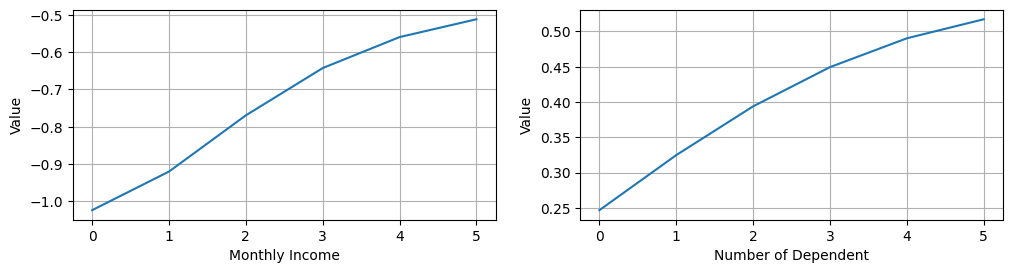

In [67]:
ind=0
visu=[]
for i in range(len(X[0])):
  if(i in monotonic_feature):
    visui=[]
    for j in range(len(individual_output[ind])):
      temp=np.zeros(len(X[0]))
      temp[i]=individual_output[ind][j]
      individual_output_now = Model.calc_outputs([temp], training=True)
      visui.append(individual_output_now[i-2])
    visu.append(visui)
    ind+=1

fig = plt.figure(figsize=(12,6))
plt.subplot(2, 2, 1)
plt.xlabel('Monthly Income')
plt.ylabel('Value')
plt.plot(visu[0])
plt.grid()

plt.subplot(2, 2, 2)
plt.xlabel('Number of Dependent')
plt.ylabel('Value')
plt.plot(visu[1])
plt.grid()


###None monotonicity (feature 5,6,7,8,9,10)

In [68]:
def none_descretize_single(monotonic_feature,lower_bound,upper_bound,spli,X):
  none_individual_output=[]
  bar=np.zeros(len(monotonic_feature))
  for i in range(len(monotonic_feature)):
    none_individual_output.append(np.linspace(lower_bound[i], upper_bound[i], num=spli[i]))
  return none_individual_output


none_monotonic_feature=[5,6,7,8,9]
none_lower_bound=[0,0,0,0,0]
none_upper_bound=[10,10,10,10,10]
none_spli=[11,11,11,11,11]
none_individual_output=none_descretize_single(none_monotonic_feature,none_lower_bound,none_upper_bound,none_spli,X)

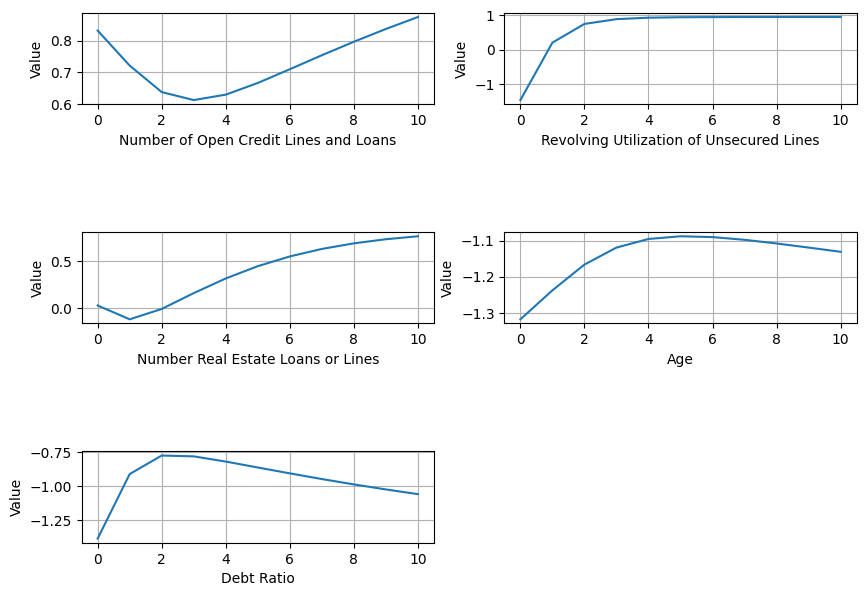

In [69]:
ind=0
visu=[]
for i in range(len(X[0])):
  if(i in none_monotonic_feature):
    visui=[]
    for j in range(len(none_individual_output[ind])):
      temp=np.zeros(len(X[0]))
      temp[i]=none_individual_output[ind][j]
      none_individual_output_now = Model.calc_outputs([temp], training=True)
      visui.append(none_individual_output_now[i-2])
    visu.append(visui)
    ind+=1

fig = plt.figure(figsize=(10,14))
plt.subplot(10, 2, 1)
plt.xlabel('Number of Open Credit Lines and Loans')
plt.ylabel('Value')
plt.plot(visu[0])
plt.grid()

plt.subplot(10, 2, 2)
plt.xlabel('Revolving Utilization of Unsecured Lines')
plt.ylabel('Value')
plt.plot(visu[1])
plt.grid()

plt.subplot(10, 2, 5)
plt.xlabel('Number Real Estate Loans or Lines')
plt.ylabel('Value')
plt.plot(visu[2])
plt.grid()

plt.subplot(10, 2, 6)
plt.xlabel('Age')
plt.ylabel('Value')
plt.plot(visu[3])
plt.grid()

plt.subplot(10, 2, 9)
plt.xlabel('Debt Ratio')
plt.ylabel('Value')
plt.plot(visu[4])
plt.grid()


###Strong pairwise (feature 1,2,3)

###This is an exmaple showing the strong pairwise monotonicity regarding feature_1 and feature_2, the value of feature_3 is arbitarly set as 0,1,2,3,4

feature 3 is 0
[[-0.36201632  0.93192273  1.61880374  1.88398612  2.00709987]
 [ 0.34419388  1.32010484  1.78177595  1.98489809  2.09384036]
 [ 0.84441018  1.52987885  1.88703716  2.06978536  2.17375374]
 [ 1.15019071  1.65716648  1.9682312   2.14541221  2.2469461 ]
 [ 1.34824419  1.7469151   2.03591609  2.21278286  2.31260443]]


<ipython-input-70-008a18453e0e>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter3D(x,y,z, cmap='Blues')


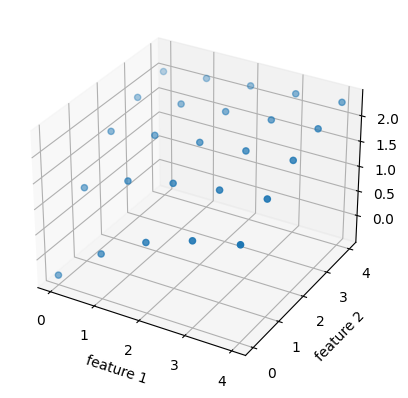

In [70]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax1 = plt.axes(projection='3d')

dx=np.linspace(0,4,5)
dy=np.linspace(0,4,5)
x=[]
y=[]
z=[]
ma=np.zeros((5,5))
temp=np.zeros(len(X[0]))
temp[2]=0
for i in range(5):
  for j in range(5):
    x.append(dx[i])
    y.append(dy[j])
    temp[0]=dx[i]
    temp[1]=dy[j]
    h=Model.calc_outputs([temp], training=True)
    z.append(h[0])
    ma[i][j]=np.array(h[0])
z=np.array(z)
ax1.scatter3D(x,y,z, cmap='Blues')
ax1.set_xlabel('feature 1')
ax1.set_ylabel('feature 2')
print("feature 3 is 0")
print(ma)

<ipython-input-71-83896e973d29>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter3D(x,y,z, cmap='Blues')


feature 3 is 1
[[1.36708832 2.1168952  2.37747002 2.47082996 2.51655531]
 [1.80736613 2.2789607  2.44641781 2.51392365 2.55011582]
 [2.02569032 2.35650992 2.48871183 2.54593372 2.57678843]
 [2.13034487 2.39783525 2.51767135 2.57064676 2.59809113]
 [2.18214178 2.42106152 2.53817701 2.58980346 2.61502218]]


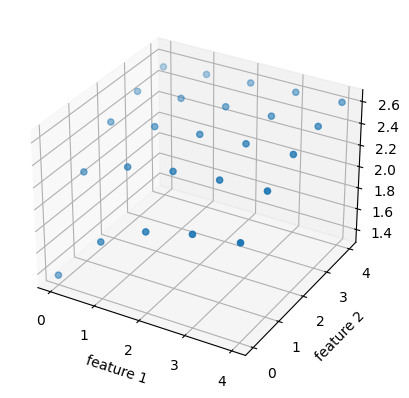

In [71]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax1 = plt.axes(projection='3d')

dx=np.linspace(0,4,5)
dy=np.linspace(0,4,5)
x=[]
y=[]
z=[]
ma=np.zeros((5,5))
temp=np.zeros(len(X[0]))
temp[2]=1
for i in range(5):
  for j in range(5):
    x.append(dx[i])
    y.append(dy[j])
    temp[0]=dx[i]
    temp[1]=dy[j]
    h=Model.calc_outputs([temp], training=True)
    z.append(h[0])
    ma[i][j]=np.array(h[0])
z=np.array(z)
ax1.scatter3D(x,y,z, cmap='Blues')
ax1.set_xlabel('feature 1')
ax1.set_ylabel('feature 2')
print("feature 3 is 1")
print(ma)

feature 3 is 2
[[2.28396797 2.55112457 2.62541056 2.64865351 2.65853643]
 [2.45104051 2.59880018 2.64225912 2.65754795 2.66480112]
 [2.51506472 2.61781788 2.65104604 2.66349649 2.669487  ]
 [2.53818274 2.62585545 2.6562674  2.66776276 2.67307043]
 [2.54418755 2.62886906 2.65949345 2.67088079 2.67582273]]


<ipython-input-72-9f300e1b6b04>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter3D(x,y,z, cmap='Blues')


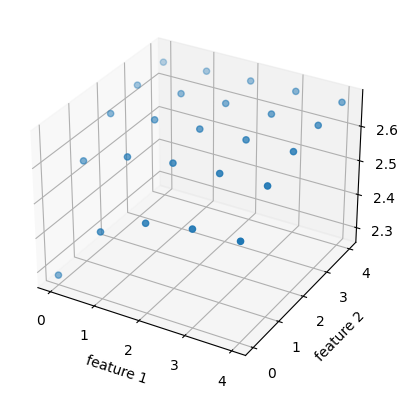

In [72]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax1 = plt.axes(projection='3d')

dx=np.linspace(0,4,5)
dy=np.linspace(0,4,5)
x=[]
y=[]
z=[]
ma=np.zeros((5,5))
temp=np.zeros(len(X[0]))
temp[2]=2
for i in range(5):
  for j in range(5):
    x.append(dx[i])
    y.append(dy[j])
    temp[0]=dx[i]
    temp[1]=dy[j]
    h=Model.calc_outputs([temp], training=True)
    z.append(h[0])
    ma[i][j]=np.array(h[0])
z=np.array(z)
ax1.scatter3D(x,y,z, cmap='Blues')
ax1.set_xlabel('feature 1')
ax1.set_ylabel('feature 2')
print("feature 3 is 2")
print(ma)

<ipython-input-73-ac78cb430594>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter3D(x,y,z, cmap='Blues')


feature 3 is 3
[[2.57349658 2.6547718  2.67521191 2.68090677 2.68294096]
 [2.62834287 2.66849279 2.67924285 2.68260241 2.68397808]
 [2.64677    2.67323732 2.68098235 2.68359709 2.68471146]
 [2.6524229  2.67484856 2.68183947 2.68425322 2.68525553]
 [2.65313721 2.67517567 2.68227148 2.68470383 2.68566465]]


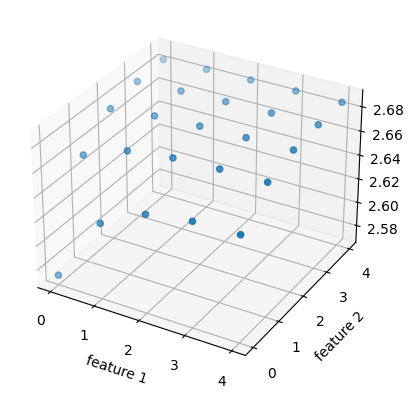

In [73]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax1 = plt.axes(projection='3d')

dx=np.linspace(0,4,5)
dy=np.linspace(0,4,5)
x=[]
y=[]
z=[]
ma=np.zeros((5,5))
temp=np.zeros(len(X[0]))
temp[2]=3
for i in range(5):
  for j in range(5):
    x.append(dx[i])
    y.append(dy[j])
    temp[0]=dx[i]
    temp[1]=dy[j]
    h=Model.calc_outputs([temp], training=True)
    z.append(h[0])
    ma[i][j]=np.array(h[0])
z=np.array(z)
ax1.scatter3D(x,y,z, cmap='Blues')
ax1.set_xlabel('feature 1')
ax1.set_ylabel('feature 2')
print("feature 3 is 3")
print(ma)

<ipython-input-74-a025910b5141>:25: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax1.scatter3D(x,y,z, cmap='Blues')


feature 3 is 4
[[2.65487528 2.67901325 2.68482399 2.68632364 2.68678355]
 [2.67236376 2.6831522  2.68590045 2.68668556 2.68696356]
 [2.67789173 2.68446493 2.68629193 2.68686247 2.68707943]
 [2.67949414 2.68485069 2.68644571 2.68696451 2.68716121]
 [2.67967749 2.68489027 2.68650007 2.68702745 2.68722081]]


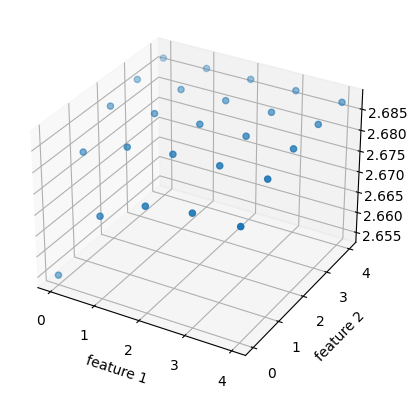

In [74]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax1 = plt.axes(projection='3d')

dx=np.linspace(0,4,5)
dy=np.linspace(0,4,5)
x=[]
y=[]
z=[]
ma=np.zeros((5,5))
temp=np.zeros(len(X[0]))
temp[2]=4
for i in range(5):
  for j in range(5):
    x.append(dx[i])
    y.append(dy[j])
    temp[0]=dx[i]
    temp[1]=dy[j]
    h=Model.calc_outputs([temp], training=True)
    z.append(h[0])
    ma[i][j]=np.array(h[0])
z=np.array(z)
ax1.scatter3D(x,y,z, cmap='Blues')
ax1.set_xlabel('feature 1')
ax1.set_ylabel('feature 2')
print("feature 3 is 4")
print(ma)

#AUC of the Model

In [76]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
y_pred=np.array(Model(X))
roc_auc_score(Y, y_pred)

0.8512179412765748